# Seasonal ARIMA 

Our second model is the Seasonal ARIMA model (sometimes abbreviated as SARIMA), which is one of the most widely used time series modeling methods along with Holt-Winters' method. ARIMA models mainly use information from the autocorrelation in the time series data for modeling and forecasting purposes- the idea being that if future values of a variable are be strongly correlated with its past values, then knowing the past values should allow you to make good predictions. The Seasonal ARIMA usually is denoted as _ARIMA(p,d,q)(P,D,Q)m_ where each one of _p, d, q, P, D,_ and _Q_ denotes a different parameter within the model. Before fitting a model, we must determine appropriate values for each of them via a number of methods.

Just like in the previous notebook, we start by loading up our data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX

bike = pd.read_csv('./data/rides_monthly_aggregate.csv', usecols = [1])
bike.set_index(pd.period_range('1/1/2013', freq='M', periods=84), inplace = True)

First, we must determine _d_ and _D_ by considering if our data is stationary, and if not, what type of differencing must we apply in order to get stationary data. Given the strong seasonality that we've already identified in our data, we start with seasonally differencing our data to see if it can produce stationary data:

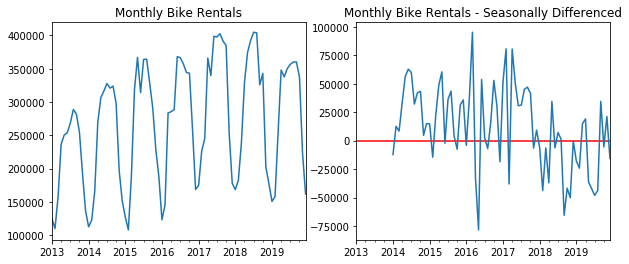

In [2]:
bike['seasonal_diff'] = bike.diff(periods = 12)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig = bike['num_rides'].plot(ax = axes[0], title = "Monthly Bike Rentals")
fig = bike['seasonal_diff'].plot(ax = axes[1], title = "Monthly Bike Rentals - Seasonally Differenced")
axes[1].hlines(0, bike.index[0], bike.index[-1], 'r');

<br>

Above, the plot of the bike rental data is given on the left, while the seasonally differenced data is given on the right. Visually, it seems like seasonal differencing has done well in making our data stationary, so we'll proceed with the ARIMA modeling with a single application of seasonal differencing, so we'll set _d = 0_ and _D = 1_ for our model.

For determining suitable values for _p, q, P,_ and _Q_, we will need to look at the ACF and PACF plots of the seasonally differenced data:

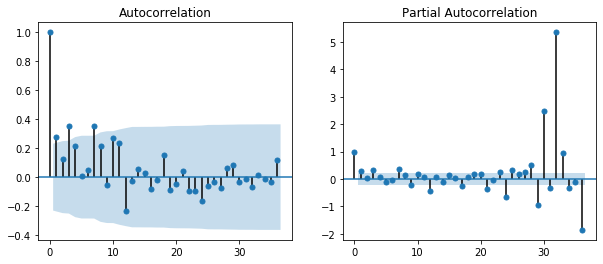

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig = sm.graphics.tsa.plot_acf(bike['seasonal_diff'].iloc[12:], lags=36, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(bike['seasonal_diff'].iloc[12:], lags=36, ax=axes[1]);

<br>

In general, we use spikes in the ACF plot to identify potential values to set for the order of the moving average (MA) component of our Seasonal ARIMA model and spikes in the PACF plot to identify potential values to set for the autoregressive (AR) component. We'll first notice that in the ACF plot, there are a number of spikes outside of the shaded region for low valued lags. This suggests that we might want to consider an ARIMA model with a low-ordered non-seasonal MA component (represented by _q_). For the PACF plot, we see growing spikes at multiples of the seasonal period (12, 24, 36), so I decided to set the seasonal AR component (represented by _P_) to 1. Recall that there were no spikes at lags of multiples of the seasonal period in the ACF plot, so I decided to set the seasonal MA component (represented by _Q_) to 0.

The order of the season and non-seasonal MA and AR components generally do not go beyond 2, so we can considering testing out a number of models to see which one performs best. What we can do is perform a grid search over potential values for _p_ and _q_ (since I've manually set _P_ and _Q_, we only need to search for these other two parameters) and compare AICc (Akaike Information Criterion with a correction) values. I iterated over _(0, 1, 2)_ for both _p_ and _q_ and recorded the AICc values of each respective model in a 3x3 dataframe as follows:

In [4]:
# Try a number of Seasonal ARIMA models so we can choose the one with lowest AICc
sarima_models = pd.DataFrame(np.zeros((3,3), dtype=float))

for p in range(3):
    for q in range(3):
        fit_sarima = SARIMAX(bike['num_rides'], order = (p,0,q), seasonal_order=(1,1,0,12)).fit()

        try:
            sarima_models.iloc[p,q] = fit_sarima.aicc
        except:
            sarima_models.iloc[p,q] = np.nan

sarima_models

,0,1,2
0,1722.721495,1722.403702,1724.214725
1,1722.460652,1716.695980,1717.196539
2,1724.634698,1724.740077,1718.099226


<br>

Based off AICc values, I proceeded with using an ARIMA(1,0,1)(1,1,0)12 model for fitting our data and performing forecasts (as it had the lowest AICc value). Note that to be more thorough, I could have ran a grid search over different values of _P_ and _Q_ as well, but this model should be powerful enough to capture the general patterns found in the bike rental data:

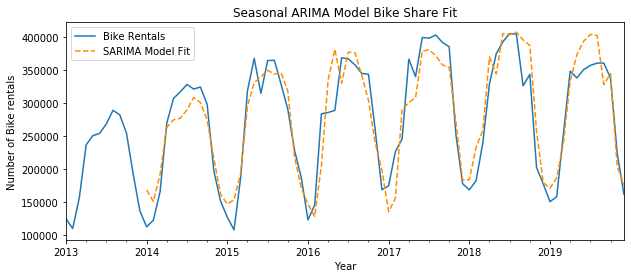

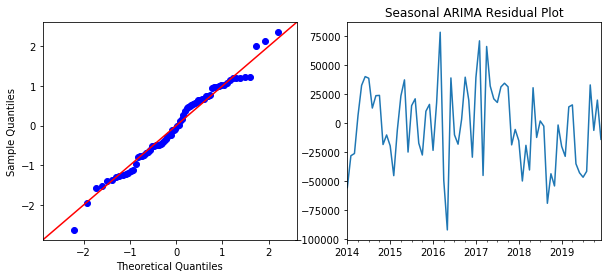

In [9]:
# The model with the lowest AICc had p = q = 1, so we fit an ARIMA(1,0,1)(1,1,0)12 model
fit_sarima = SARIMAX(bike['num_rides'], order = (1,0,1), seasonal_order=(1,1,0,12)).fit()

# Plot the fit of the Seasonal ARIMA model
bike_plot = bike['num_rides'].plot(figsize = (10,4), title = "Seasonal ARIMA Model Bike Share Fit")
bike_plot.set_ylabel("Number of Bike rentals")
bike_plot.set_xlabel("Year")

fit_sarima.fittedvalues.iloc[12:].plot(ax = bike_plot, style = '--', color = 'DarkOrange')
bike_plot.legend(['Bike Rentals', 'SARIMA Model Fit'])

# Plot the QQ plot and residual plot
fig, axes = plt.subplots(1, 2, figsize=(10,4))

fig = sm.qqplot(fit_sarima.resid.iloc[12:], line='45', fit=True, ax=axes[0])
fig = fit_sarima.resid.iloc[12:].plot(title="Seasonal ARIMA Residual Plot", ax=axes[1]);

<br>

As the data requires seasonal differencing, it makes sense to only look at how well the model fits past the first 12 months (hence the missing model fit from year 2013). The model fit is generally good, but visually we can see that the Seasonal ARIMA model adheres much stronger than our previous model using Holt-Winters' method to variations that occured in each previous seasonal period- each year within the model fit strongly resembles the previous year's monthly bike rental data, down to the monthly ups and downs. 

A look at the QQ plot shows that the normality assumption for the residuals' distribution is reasonable- although there is a noticeable outlier towards the bottom right of the plot. The residual plot shows a similar story in that there is no visibly detectable pattern, so we conclude it is reasonable to assume that the residuals are not autocorrelated, nor is there "leftover" information in the errors that may improve the model. With these two things checked, we can proceed with using the model for forecasting purposes:

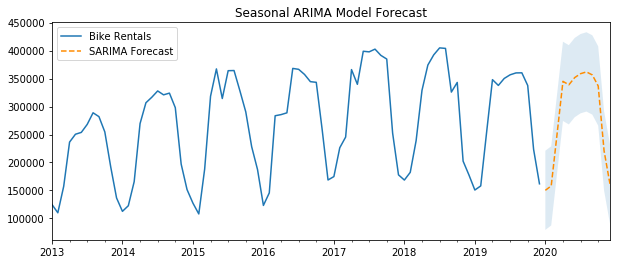

In [6]:
# Get the prediction intervals from the fitted model's .get_forecast() method
pred_int = fit_sarima.get_forecast(12).conf_int()

# Plot the bike rental data along with Seasonal ARIMA forecast and prediction intervals
bike_plot = bike['num_rides'].plot(figsize = (10,4), title = "Seasonal ARIMA Model Forecast")
fit_sarima.forecast(12).plot(ax = bike_plot,style = '--', color = 'DarkOrange')
bike_plot.fill_between(fit_sarima.forecast(12).index, pred_int.iloc[:,0], pred_int.iloc[:,1], alpha=0.15)
bike_plot.legend(['Bike Rentals', 'SARIMA Forecast'], loc='upper left');

<br>

Since the Seasonal ARIMA model is an actual statistical model, it is possible to derive prediction intervals to accompany the forecasted values. Here we have the forecasted mean monthly bike rentals as the dashed orange like, while the shaded regions are the corresponding 95% prediction intervals. The Seasonal ARIMA model forecasts bike rental numbers in 2020 to look very similarly to as they were in 2019- this shouldn't come as a surprise as our previous examination of the model fit had each year being very similar to the previous, and the forecast is just a continuation of this.

The particular forecasted mean bike rental numbers for 2020 from the Seasonal Arima model is given in the following:

In [10]:
fit_sarima.forecast(12)

2020-01    150253.197075
2020-02    158139.301341
2020-03    251066.496941
2020-04    345004.396296
2020-05    338788.741969
2020-06    351707.047094
2020-07    358694.026182
2020-08    361838.662430
2020-09    356420.288249
2020-10    336681.052600
2020-11    220768.497582
2020-12    161840.195846
Freq: M, dtype: float64

<br>

[Previous](https://github.com/Christopher-Liu/bikeshare-ts-analysis/blob/master/3-Modeling_Seasonal_ARIMA.ipynb)

1. [Data Aggregation and EDA](https://github.com/Christopher-Liu/bikeshare-ts-analysis/blob/master/1-Data_Aggregation_and_EDA.ipynb)

2. [Modeling: Holt-Winters' Method](https://github.com/Christopher-Liu/bikeshare-ts-analysis/blob/master/2-Modeling_Holt-Winters_Method.ipynb)

3. [__Modeling: Seasonal ARIMA__](https://github.com/Christopher-Liu/bikeshare-ts-analysis/blob/master/3-Modeling_Seasonal_ARIMA.ipynb)
